In [168]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

# ==============================
# User defined 
# ==============================
import plot_data as pt
import torch_optimizer as tr_opt

In [169]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
# H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])
H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])
# H_1 = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0)])

## Legacy

#### Common use

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

## New Hamiltonian

#### Entangler Hamiltonian

$$
H = -0.5 \, Z_0 \otimes Z_1
$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

#### Phase Accumulator Hamiltonian


$$
H_{1} = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [170]:
test = np.array([
    [1,0],
    [0,-1]
])

res = np.kron(test, test)

res

array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  1]])

In [171]:
# Global Parameters
Tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)   # Dephase tau
Gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
Paras_global = torch.tensor([0, 0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau} \\[1em]

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$

$$
\\[1em]
Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [172]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    tau_1 = Paras_global[1]
    tau_2 = Paras_global[2]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(torch.pi/2, wires=0)
    qml.RY(torch.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    # qml.PhaseDamping(gamma_dephase, wires = 0)
    # qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-torch.pi/2, wires = 0)    
    qml.RY(-torch.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    # qml.PhaseDamping(gamma_dephase, wires = 0)
    # qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(torch.pi/2, wires = 0)    
    qml.RY(torch.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.RX(torch.pi/(2), wires=0)
    qml.RX(torch.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

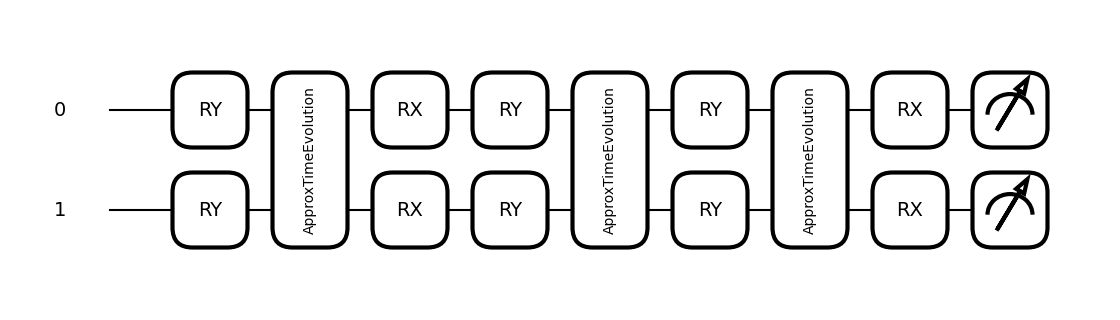

In [173]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [174]:
@qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=torch.complex128)
    
    Numerator = torch.kron(K, torch.eye(2)) @ get_density_matrix @ torch.kron(K, torch.eye(2)).conj().T
    Denominator = torch.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})]}
$$

In [175]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor([desired_gamma_post_selection])

In [176]:
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [177]:
def plot_test():
    global Paras_global
    # set circuit
    set_circuit(0, 0.8)
    Paras_global = torch.tensor([torch.pi/2, torch.pi/2, torch.pi/2])
    
    PHI = torch.arange(0, 3*torch.pi, 1e-1)
    Data_temp = torch.zeros((len(PHI), 2))
    Data_temp[:, 0] = PHI

    for idx, phi_current in enumerate(PHI):
        phi_temp = torch.tensor([phi_current])
        Data_temp[idx][1] = qml.qinfo.classical_fisher(Post_selection)(phi_temp)

    Data_temp = Data_temp.detach().numpy() 
    
    plt.plot(Data_temp[:,0], Data_temp[:,1], label = f'$\gamma$ = {Gamma_ps_global}')

    plt.title('CFI by selected gamma')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid()
    
# plot_test()

In [178]:
def torch_optimization(sweep_range, initial_parameters, method):
    """ 
    Perform optimization using specified optimizer over a range of phi values.

    Args:
        sweep_range (list): Range of phi values for optimization.
        initial_parameters (torch.Tensor): Initial parameters for optimization.
        method (str): Optimization method ('LBFGS' or 'Adam').

    Returns:
        torch.Tensor: Data tensor containing optimization results.
    """
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    opt = tr_opt.select_optimizer(method, params_tensor)
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 1
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-10
        
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)
        
        if Phi[phi_idx] < 10:
            steps = 100
        else:
            steps = 1

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            # print(f"{i+1:03d}th iteration, CFI=", fval)
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        print("CFI =", -fval, "Paras =", opt.param_groups[0]['params'][0].detach().numpy())
        
        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]
        
        # torch.cat(([-fval], opt.param_groups[0]['params'][0].detach().numpy()))


    return Data

In [179]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """ 
    Iterate over different values of tau_dephase and gamma_post_selection for optimization.

    Args:
        sweep_range (list): Range of phi values for optimization.
        init_par (torch.Tensor): Initial parameters for optimization.
        tau_dephase (list): List of dephasing rates tau to iterate over.
        gamma_post_selection (float): Post-selection rate gamma.
        method (str): Optimization method.

    Returns:
        np.ndarray: Numpy array with optimization results for each tau.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = torch_optimization(sweep_range, init_par, method).detach().cpu().numpy()
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [180]:
sweep_range = torch.tensor([1e-2, 3*torch.pi, 1e-2], dtype=torch.float, requires_grad=False)
init_par = torch.tensor([torch.pi/2, torch.pi/2, torch.pi/2], dtype=torch.float)
tau_dephase = 0, 5e-2, 2e-1, 5e-1, 1, 2, 3, 4
gamma_ps = 0

res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGS')

CFI = 0.00045872995008551515 Paras = [1.6050558 1.5707964 1.5707964]
CFI = 0.005153127764016512 Paras = [1.8481295 1.5707964 1.5707964]
CFI = 3.9999977209788424 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999998885194862 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999999336745865 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.9999996337967296 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999999625009572 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999999940446846 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 4.000000330728183 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999999879414367 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.9999997197999266 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999999938557787 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.9999995716827623 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 3.999999441430028 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 4.0000001092963515 Paras = [2.3562155 1.5707964 1.5707964]
CFI = 4.000000416878532 Par

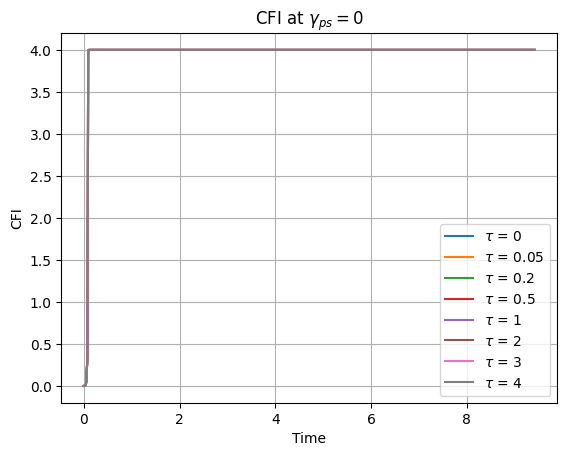

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'CFI')

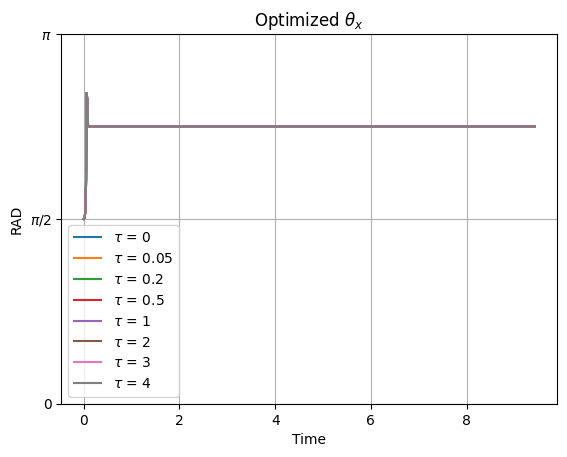

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'theta_x')

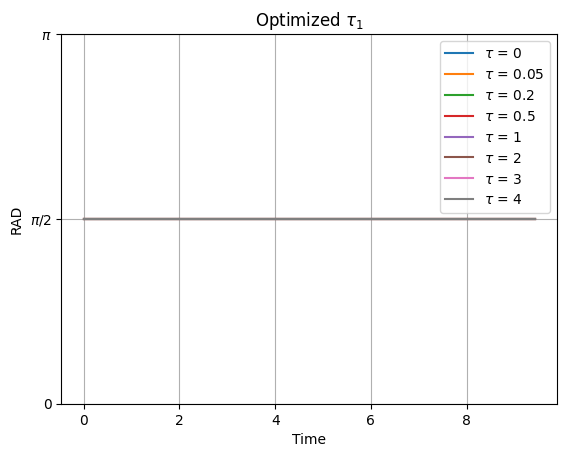

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'tau_1')

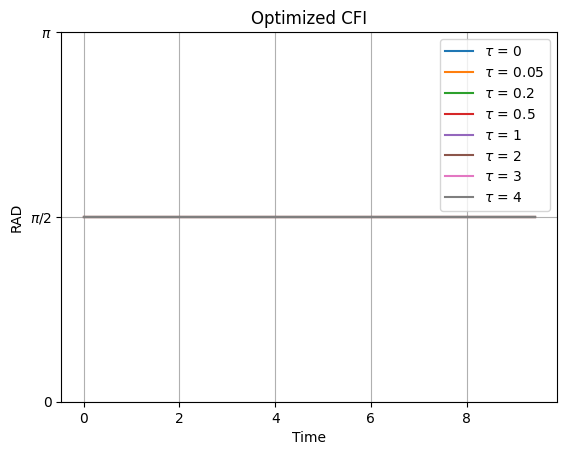

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'tau_2')